# A Bayesian Framework for Persistent Homology
#### Authors: Christopher Oballe, Vasileios Maroulas

Herein, we provide a tutorial for a Python module that implements the model for Bayesian inference with persistence diagrams introduced in https://epubs.siam.org/doi/pdf/10.1137/19M1268719.

The module is hosted on github at https://github.com/maroulaslab/bayes_tda_python. It can also be installed from PyPI with the command:
```shell
pip install bayes_tda
```

# Basic Usage

We'll demonstrate how to use our code to create posterior distributions for persistence diagrams by looking at one of TDA's popular toy datasets, the noisy circle.

In [1]:
import numpy as np

np.random.seed(0)

# noisy circle sample
n_pts = 100
noise_lev = 0.1
t = np.linspace(0,1,n_pts)
x,y = np.cos(2*np.pi*t), np.sin(2*np.pi*t)
circ = np.array([[h,v] for h,v in zip(x,y)])
noise = np.random.normal(scale = noise_lev,size = [n_pts,2])
n_circ = circ+noise

Let's visualize our data.

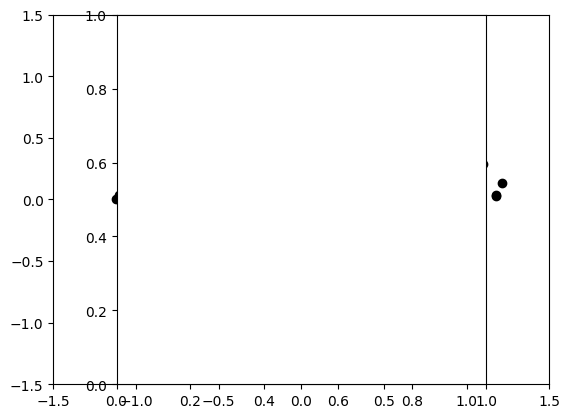

In [2]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(circ[:,0],circ[:,1], color = 'red') # circle
plt.scatter(n_circ[:,0],n_circ[:,1], color = 'black') # noisy sample
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.axes().set_aspect('equal')
plt.show()
plt.close()

Next, we'll compute the Rips filtration for our point cloud.

In [3]:
import gudhi as gd
hom_dim = 1
st = gd.RipsComplex(points=n_circ, max_edge_length=3.).create_simplex_tree(max_dimension=hom_dim + 1)
dgm = st.persistence()

In this demonstration, we'll focus on modeling the distribution of the feature that corresponds to the large hole in the middle of the circle. Hence, we only consider 1-dimensional homological features. Let's compute and visulaize the 1-dimensional persistence diagram for our data. 

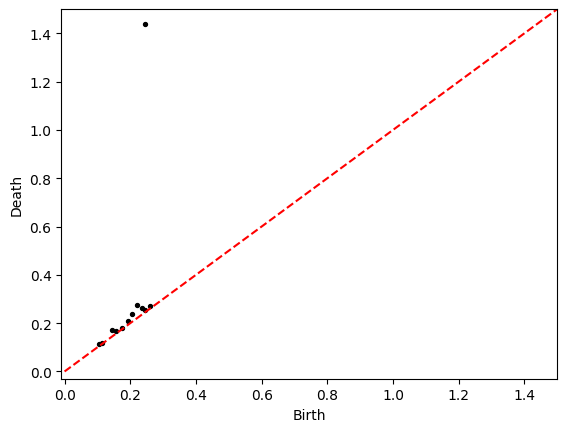

In [4]:
#hom_dim = 1
pairs = st.persistence_pairs()
simps = [s for s in filter(lambda x: len(x[0]) == hom_dim + 1,pairs)]
pd = np.array([[st.filtration(x),st.filtration(y)] for x,y in simps])

plt.figure()
plt.scatter(pd[:,0],pd[:,1], s = 8 ,color = 'black')
plt.plot([0,1.5],[0,1.5],ls = '--',color = 'red')
plt.xlim([-0.01,1.5])
plt.ylim([-0.03,1.5])
plt.xlabel('Birth')
plt.ylabel('Death')
plt.show()
plt.close()

The bayes_tda module works with persistence diagrams given in birth-persistence (where persistence = death - birth) instead of birth-death coordnates. We can convert our diagram to birth-persistence coordinates in one line of code then visualize the transformed diagram.

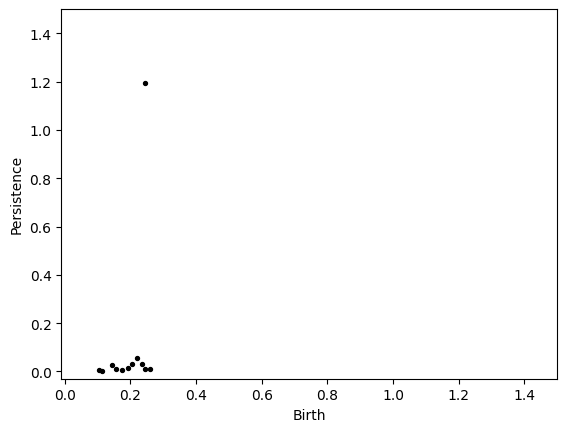

In [5]:
pd_t = np.array([[b,d-b] for b,d in pd])

plt.figure()
plt.scatter(pd_t[:,0],pd_t[:,1], s = 8 ,color = 'black')
plt.xlim([-0.01,1.5])
plt.ylim([-0.03,1.5])
plt.xlabel('Birth')
plt.ylabel('Persistence')
plt.show()
plt.close()

Our Bayesian model views a persistence diagram $\mathcal{D}$ as a sample from a point process $D$, which is a random collection of elements whose cardinality may vary. A useful summary statistic of a point process is its intensity,$\lambda$, which satisfies $\mathbb{E}(|D \cap \mathcal{A}|) = \int _{A}\lambda(x)\,dx$ for every $A \subset \mathbb{W} := \{(b,p) \in \mathbb{R}^2:b >0\}$. Our Bayesian model gives a recipe to compute posterior intensities using prior intensities, a likelihood, and observed persistence diagrams. In our implementation, the prior intensity $\lambda _D(x)$ is given by a Gaussian mixture. 
\begin{equation}
\lambda\_D(x) = \sum\_{i=1}^{N} w_i\mathcal{N}^'(x;\mu_i,\sigma_i I), 
\end{equation}
where $N$ is the number of mixture components, $w_i$ are weights, and 
\begin{equation}
\mathcal{N}^'(x;\mu_i,\sigma_i I) = \begin{cases}\mathcal{N}(x;\mu_i,\sigma_i I), x \in \mathbb{W} \newline
                                                    0, \mathrm{otherwise}
                                    \end{cases}
\end{equation}
where $\mathcal{N}(x;\mu_i,\sigma_i I)$ is the Gaussian density, with mean $\mu _i$ and covariance matrix $\sigma _i I$. Thus, we can create prior intensities by specifying the means, covariances, and weights of each mixture component, respectively. Below, we demonstrate the syntax for doing so.

In [6]:
from bayes_tda import *

mu_pri = np.array([[0.2,1]]) # prior mean
w_pri = np.array([1]) # prior weight
sig_pri = np.array([0.25]) # prior covariance magnitude

prior_unimodal = Prior(weights = w_pri,mus = mu_pri, sigmas = sig_pri)

The object prior_unimodal corresponds to the prior intensity
\begin{equation}
\lambda\_D(x) =  \mathcal{N}^'\Big(x;(0.2,1),0.25 I\Big)
\end{equation}

We can evaluate the prior by calling
```python
prior_unimodal.eval(x)
```
e.g.,

In [7]:
prior_unimodal.eval([0.2,1]), prior_unimodal.eval([0.1,0.2]), prior_unimodal.eval([1,-0.1])

(0.6366197723675814, 0.17349912804424186, 0)

Notice that the point $(1,-0.1)$ evaluates to 0. Since we work with homologoical features in birth-persistence coordinates, our model assigns probability zero to any point with negative persistence. Another component of our model is an intensity for unanticipated features,which measures the probability that features arise from noise instead of characteristic topology in the data. This intensity, which is another Gaussian mixture supplied by the user, serves as another source of prior information and prevents overfitting the posteriors to noise. In this example since the noise level is relatively low, we anticipate that features whose persistences are close to zero are the result of noise. We leverage this in creating our intensity for unanticipated features.     

In [8]:
mu_u = np.array([[0.15,0.01],[0.2,0.01],[0.25,0.01]]) # unanticipated features means
w_u = np.array([2,2,2]) # unanticipated features weights
sig_u = np.array([0.05,0.05,0.05]) # unanticipated features covariance magnitudes

prior_unant = Prior(weights = w_u,mus = mu_u, sigmas = sig_u)

The last ingredient we need to compute a posterior distribution is a likelihood $\ell$, which in our implementation is given by a restricted Gaussian density, 
\begin{equation}
\ell(y|x) = \mathcal{N}^'(y;x,\sigma\_L I)
\end{equation}

In [9]:
sl = 0.3 # magnitude of covariance matrix for likelihood

Finally, we compute the posterior distribution with one last line of code.

In [10]:
posterior = Posterior(prior = prior_unimodal,clutter = prior_unant, Dy = pd_t, sy = sl)

Respectively assuming that our prior and likelihood is a restricted Gaussian mixture and a restricted Gaussian density results in a posterior that is a resticted Gaussian mixture (this is known as conjugacy in Bayesian inference). The exact equations for the posterior means, weights, and covariance matrices may be found in https://epubs.siam.org/doi/pdf/10.1137/19M1268719. Let's visualize our posterior.

C:\Users\Administrator\AppData\Local\Temp\ipykernel_20068\2524866769.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-bright')


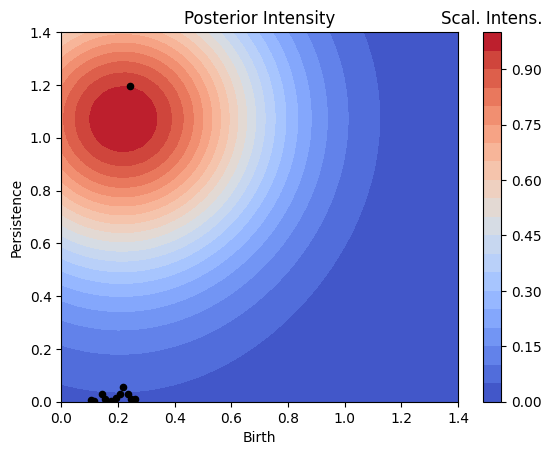

In [11]:
# create grid for computing posterior intensity
b = np.linspace(0,1.4,50)
p = np.linspace(0,1.4,50) 
B,P = np.meshgrid(b,p)

# evaluate posterior intensity over grid
I = list()
for ind in range(len(P)):
    l = list()
    for i in range(len(P)):
        l.append(posterior.eval([B[ind][i],P[ind][i]]))
    I.append(l)
I = I / np.max(I)

# plot posterior intensity
plt.figure()        
plt.style.use('seaborn-bright')
plt.contourf(B,P,I, 20, cmap = 'coolwarm', vmin = 0, vmax = 1)
plt.title('Posterior Intensity')
cb = plt.colorbar()
cb.ax.set_title('Scal. Intens.')
plt.gca().set_ylabel('Persistence')
plt.gca().set_xlabel('Birth')
plt.xlim([0,1.4])
plt.ylim([0,1.4])
plt.scatter(pd_t[:,0],pd_t[:,1], s = 20 ,color = 'black') # overlay persistence diagram
plt.show()
plt.close()

# Machine Learning Example: Classification

Next, we'll give an example of how our Bayesian framework can be used in machine learning problems. We'll consider the problem of distinguishing circles from ovals. First, we define some auxillary functions to create our datasets.

In [12]:
# draw samples from circle
def noisy_circ(n_pts,noise_lev = 0.1):
    t = np.linspace(0,1,n_pts)
    x,y = np.cos(2*np.pi*t), np.sin(2*np.pi*t)
    circ = np.array([[h,v] for h,v in zip(x,y)])
    noise = np.random.normal(scale = noise_lev,size = [n_pts,2])
    n_circ = circ+noise
    return n_circ

# draw samples from oval
def noisy_oval(n_pts,noise_lev = 0.1):
    t = np.linspace(0,1,n_pts)
    x,y = 1.5*np.cos(2*np.pi*t), np.sin(2*np.pi*t)
    oval = np.array([[h,v] for h,v in zip(x,y)])
    noise = np.random.normal(scale = noise_lev,size = [n_pts,2])
    n_oval = oval+noise
    return n_oval

Now, we'll create 100 noisy circle and ovals, respectively.

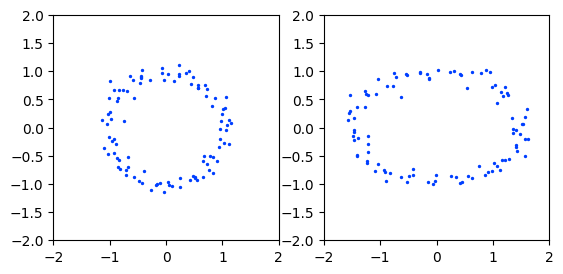

In [13]:
n_pts, data_sz = 100,100
circs,ovals = [noisy_circ(n_pts) for i in range(data_sz)], [noisy_oval(n_pts) for i in range(data_sz)]

# visualize the data
c,o = circs[0], ovals[0]
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(c[:,0], c[:,1], s = 2)
ax1.set_ylim([-2,2])
ax1.set_xlim([-2,2])
ax1.set_aspect('equal')
ax2.scatter(o[:,0], o[:,1], s = 2)
ax2.set_ylim([-2,2])
ax2.set_xlim([-2,2])
ax2.set_aspect('equal')

Next, we compute the Rips filtrations and 1-dimensional persistence diagrams (in birth-persistence cooridnates) for each of these point clouds.

In [14]:
def pd_tilted(point_cloud, hom_dim = 1):
    st = gd.RipsComplex(points=point_cloud, max_edge_length=3.).create_simplex_tree(max_dimension=hom_dim + 1)
    dgm = st.persistence()
    pairs = st.persistence_pairs()
    simps = [s for s in filter(lambda x: len(x[0]) == hom_dim + 1,pairs)]
    pd = np.array([[st.filtration(x),st.filtration(y)] for x,y in simps])
    pd_t = np.array([[b,d-b] for b,d in pd])
    return pd_t

circ_diags, oval_diags = [pd_tilted(pc) for pc in circs],[pd_tilted(pc) for pc in ovals]

Given a persistence diagram $\mathcal{D}$, we estimate the Bayes factor for the competing hypotheses '$\mathcal{D}$ corresponds to a noisy circle sample' and '$\mathcal{D}$ corresponds to a noisy oval sample', i.e. $BF(\mathcal{D}) := \frac{\mathbb{P}(\mathcal{D}|\mathrm{Circle})}{\mathbb{P}(\mathcal{D}|\mathrm{Oval})}$. Large and small values of $BF(\mathcal{D})$ provide strong evidence for the former and latter hypotheses, respectively. Although we can use our Bayesian model to compute the numerator and denominator of $BF(\mathcal{D})$, for numerical reasons, we choose instead to work with $\log BF(\mathcal{D})$. We estimate $\log \mathbb{P}(\mathcal{D}|\mathrm{Circle})$ by computing $\log \mathbb{P}(\mathcal{D}|\mathcal{T})$ using our Bayesian model, where elements of $\mathcal{T}$ are persistence diagrams associated with noisy circle samples. The Bayes factor can be used for classification, as summarized in the following schematic.
<img src="gudhi_fc.png">

The following function computes the log posterior probability $\log \mathbb{P}(\mathcal{D}|\mathcal{T})$. The function also requires the hyperparamters for computing posteriors in our framework: a prior intensity, an intensity for unanticipated features, and a covariance matrix for the likelihood. 

In [15]:
def training_posterior(D,T,prior,unant,lik_cm):
    posts = [Posterior(prior = prior, clutter = unant, Dy = diag, sy = lik_cm) for diag in T]
    pp_log = 0
    for feat in D:
        post_pri = [p.eval(feat) for p in posts]
        pp_log += np.log10(np.sum(np.array(post_pri)))
    return pp_log

We use a flat prior (i.e., one with a high covariance magnitude) and drop the unanticipated intensity by setting its weight to 0. The high uncertainty in the prior and lack of an unanticipated component lead to posteriors that are entirely data-driven. 

In [16]:
mu_pri = np.array([[0.2,1]]) # prior mean
w_pri = np.array([1]) # prior weight
sig_pri = np.array([20]) # prior covariance magnitude

pri_train = Prior(weights = w_pri,mus = mu_pri, sigmas = sig_pri)
unant = Prior(weights = np.array([0]),mus = mu_pri, sigmas = sig_pri) # unanticipated intensity set to zero

Next, we create our validation set by drawing 20 more samples each from a circle and an oval then computing persistence diagrams.

In [17]:
n_pts, data_sz = 100,20
circs_val,ovals_val = [noisy_circ(n_pts) for i in range(data_sz)], [noisy_oval(n_pts) for i in range(data_sz)]
c_dgms_val, o_dgms_val = [pd_tilted(pc) for pc in circs_val],[pd_tilted(pc) for pc in ovals_val]

Let's compute the log Bayes factors for each diagram in our validation set.

In [18]:
lbf_circs,lbf_ovals = [training_posterior(diag,T=circ_diags,prior = pri_train,unant = unant,lik_cm = 0.1)- \
                     training_posterior(diag,T=oval_diags,prior = pri_train,unant = unant,lik_cm = 0.1) for diag in c_dgms_val],\
                    [training_posterior(diag,T=circ_diags,prior = pri_train,unant = unant,lik_cm = 0.1)- \
                     training_posterior(diag,T=oval_diags,prior = pri_train,unant = unant,lik_cm = 0.1) for diag in o_dgms_val]
                     

Now, we visualize the Bayes factors to get a sense of how well our model distinguished the two classes. 

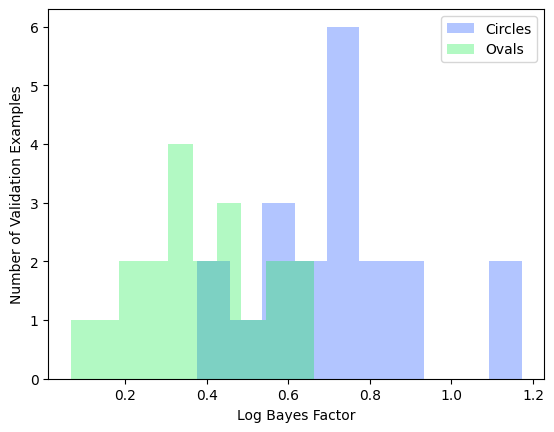

In [19]:
plt.hist(lbf_circs, alpha = 0.3)
plt.hist(lbf_ovals, alpha = 0.3)
plt.legend(['Circles','Ovals'])
plt.xlabel('Log Bayes Factor')
plt.ylabel('Number of Validation Examples')
plt.show()

On average, we notice higher Bayes factors for the circles, which was to be expected. To quantitavely assess the Bayes factor classifier, we can compute the AUC. 

In [20]:
from sklearn import metrics

class_labels = [0]*data_sz + [1]*data_sz
pred = lbf_ovals + lbf_circs
fpr, tpr, thresholds = metrics.roc_curve(class_labels, pred, pos_label=1)
metrics.auc(fpr,tpr)

0.9125

The AUC is close to 1, which indicates good performance of our classifier. 